# Анализ заведений общественного питания в Москве (Analysis of catering establishments in Moscow)

## Описание проекта

Есть открытые данные о заведениях общественного питания в Москве. Необходимо подготовить исследование рынка заведений общественного питания в городе. 

**Цель проекта:** оценить возможность открытия небольшое оригинального кафе в Москве.

**Задачи проекта:** для достижения поставленной цели необходимо подготовить исследование рынка общественного питания в Москве, особенности заведения, количество посадочных мест, район расположения, возможность развития сети.

**План проекта:**

* Изучение общей информации;
* Анализ данных;
    * Исследование соотношения видов объектов общественного питания;
    * Исследование сетевых и несетевых заведений;
    * Исследование количества посадочных мест у разных категорий заведений;
    * Исследование районов расположения заведений;
* Выводы и рекомендации.
    
**Описание данных**

Таблица `rest_data`:

* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.

## Изучение общей информации

Загрузим необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

Загрузим данные о заведениях общественного питания в Москве. Создадим функцию `df_read_csv`, которая выведит сообщение об ошибке, если информация о файле будет указана неверно

In [2]:
def df_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        print('Ошибка при загрузке файла')
rest_data = pd.read_csv('rest_data.csv')
rest_data.info()
rest_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


Выведим список характерных значений для каждого столбца

In [3]:
rest_data.describe()

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


Проверим данные в таблице. Создадим функцию `describe_cols`, которая выведит список уникальных значений и их количество в каждом столбце и применим для таблицы

In [4]:
# функция для вывода списка и количества уникальных значений в таблице
def describe_cols(df):
    values = pd.DataFrame()
    for col in df.columns:
        values[col] = [df[col].unique(),df[col].nunique()]
    return values.transpose().sort_values(by = 1, ascending = True).rename({0: 'Значения', 1: 'Количество уникальных значений'}, axis = 1)
describe_cols(rest_data) # применение функции для таблицы users

,Значения,Количество уникальных значений
chain,"[нет, да]",2
object_type,"[кафе, столовая, закусочная, предприятие быстр...",9
number,"[48, 35, 95, 40, 50, 240, 10, 90, 150, 120, 5,...",315
address,"[город Москва, улица Егора Абакумова, дом 9, г...",9108
object_name,"[СМЕТАНА, Родник, Кафе «Академия», ПИЦЦЕТОРИЯ,...",10393
id,"[151635, 77874, 24309, 21894, 119365, 27429, 1...",15366


Проверим таблицу на наличие явных дубликатов

In [5]:
rest_data[['object_name','chain','object_type','address','number']].duplicated().sum()

82

Удалим эти дубликаты

In [6]:
rest_data = rest_data[['object_name','chain','object_type','address','number']].drop_duplicates().reset_index(drop = True) # удаление явных дубликатов (с удалением старых индексов и формированием новых)
rest_data[['object_name','chain','object_type','address','number']].duplicated().sum()

0

Приведем названия заведений к нижнему регистру

In [7]:
rest_data['object_name'] = rest_data['object_name'].str.lower() # приведение данных к нижнему регистру

Приведем к единому названию самые популярные заведения

In [8]:
mac = rest_data[rest_data['object_name'].str.contains(r'\bмакд')]
mac['object_name'].unique()

array(['макдоналдс', 'ресторан «макдоналдс»',
       'предприятие быстрого обслуживания «макдоналдс»',
       'москва - макдоналдс', 'кафе макдоналдс', 'кафе «макдоналдс»',
       'ресторан«макдоналдс»'], dtype=object)

In [9]:
# создадим функцию для замены названий
def replace_wrong_name(wrong_name, correct_name):
    for wrong_name in wrong_name:
        rest_data['object_name'] = rest_data['object_name'].replace(wrong_name, correct_name)
replace_wrong_name(mac['object_name'].unique(), 'макдоналдс')

In [10]:
kfc = rest_data[rest_data['object_name'].str.contains(r'\bkfc')]
kfc['object_name'].unique()
replace_wrong_name(kfc['object_name'].unique(), 'kfc')

In [11]:
shok = rest_data[rest_data['object_name'].str.contains(r'\bшоколадница')]
shok['object_name'].unique()
replace_wrong_name(shok['object_name'].unique(), 'шоколадница')

In [12]:
burg = rest_data[rest_data['object_name'].str.contains(r'\bбургер кинг')]
burg['object_name'].unique()
replace_wrong_name(burg['object_name'].unique(), 'бургер кинг')

In [13]:
ter = rest_data[rest_data['object_name'].str.contains(r'\bтеремок')]
ter['object_name'].unique()
replace_wrong_name(ter['object_name'].unique(), 'теремок')

Посчитаем пропущенные значения

In [14]:
rest_data.isna().sum() 

object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Пропусков не обнаружено. Но Python показывает пустые значения только, если оно имеет тип NoneType. Необходимо проверить, есть ли другие пропуски в столбцах. Для этого создадим функцию nan_values.

In [15]:
# функция для вывода списка и количества уникальных значений в таблице
def nan_values(df,list_nans = ['',' ','""', '" "', None, np.nan]):
    list_count = []
    list_share = []
    for col in df.columns:
        list_count.append(sum(df[col].isin(list_nans)))
        list_share.append(round(sum(df[col].isin(list_nans)) * 100 / len(df), 2))
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'num_missing': list_count, 'percent_missing': list_share})
    return missing_value_df
nan_values(rest_data) # применение функции для таблицы 

,column_name,num_missing,percent_missing
0,object_name,0,0.0
1,chain,0,0.0
2,object_type,0,0.0
3,address,0,0.0
4,number,0,0.0


In [16]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15284 entries, 0 to 15283
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  15284 non-null  object
 1   chain        15284 non-null  object
 2   object_type  15284 non-null  object
 3   address      15284 non-null  object
 4   number       15284 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 597.2+ KB


Никаких других пропусков не обнаружено

Исследование данных завершено, перейдем к анализу данных

## Анализ данных

### Исследование соотношения видов объектов общественного питания

Исследуем соотношение видов объектов общественного питания по количеству. 

Выведим количество заведений разного типа, построим диаграмму распределения этих заведений от общего числа заведений.

object_type
кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1898
бар                                   855
буфет                                 577
кафетерий                             395
закусочная                            349
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64


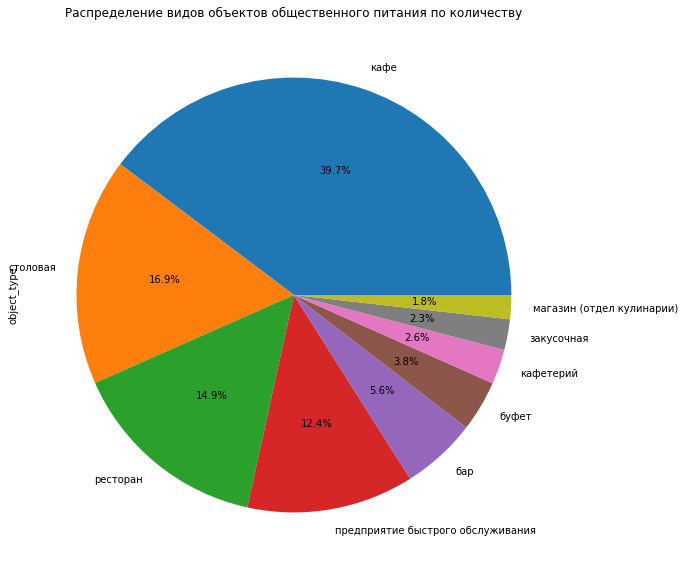

In [17]:
df_object_type = rest_data.groupby(['object_type'])['object_type'].count().sort_values(ascending = False) 
print(df_object_type);
# построение круговой диаграммы
df_object_type.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%')
plt.title('Распределение видов объектов общественного питания по количеству');

Из диаграммы видно, что больше всего заведений типа "кафе", на них приходится 39.7% от всех заведений. Также популярны столовые, рестораны и предприятия быстрого обслуживания

### Исследование сетевых и несетевых заведений

Исследуем соотношение сетевых и несетевых заведений по количеству и построим диаграмму распределения

chain
нет    12320
да      2964
Name: chain, dtype: int64


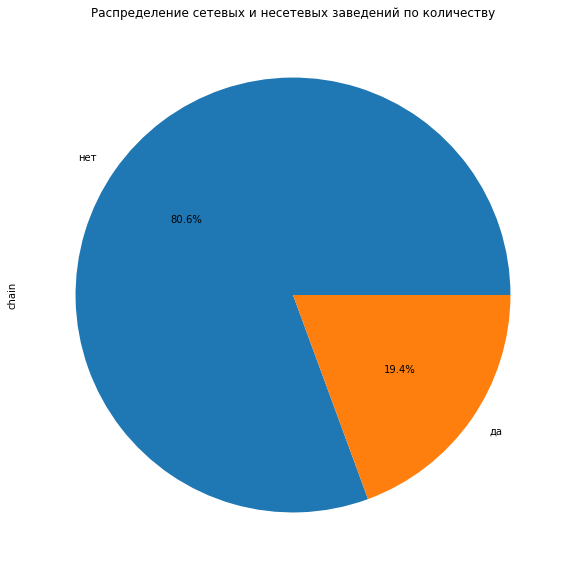

In [18]:
df_chain = rest_data.groupby(['chain'])['chain'].count().sort_values(ascending = False) 
print(df_chain);
# построение круговой диаграммы
df_chain.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%')
plt.title('Распределение сетевых и несетевых заведений по количеству');

Видим, что на долю несетевых заведений приходится 80.6% всех заведений. Можно сказать, что только каждое пятое заведение - сетевое

Определим, для какого вида объекта общественного питания характерно сетевое распространение

chain,да,нет,Доля сетевых объектов от общего числа данного типа объектов
object_type,,,
бар,37,818,4.33
буфет,11,566,1.91
закусочная,56,293,16.05
кафе,1396,4675,22.99
кафетерий,52,343,13.16
магазин (отдел кулинарии),78,195,28.57
предприятие быстрого обслуживания,788,1110,41.52
ресторан,543,1739,23.79
столовая,3,2581,0.12


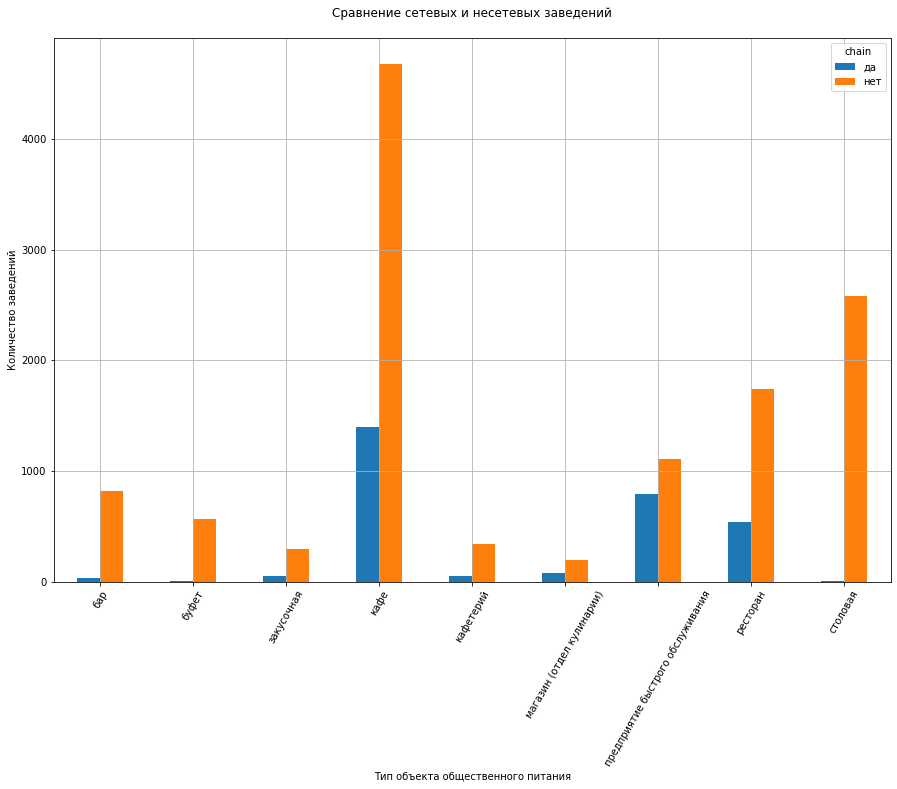

In [19]:
df_web = pd.pivot_table(rest_data, values='address', index='object_type', columns='chain', aggfunc='count')
ax = df_web.plot(kind='bar', figsize=(15,10))
plt.xticks(rotation=60)
plt.grid()
plt.title('Сравнение сетевых и несетевых заведений' + "\n")
plt.xlabel('Тип объекта общественного питания')
plt.ylabel('Количество заведений');
df_web['Доля сетевых объектов от общего числа данного типа объектов'] = round(df_web['да'] / (df_web['да'] + df_web['нет']) * 100, 2)
df_web

Можно выделить, что для предприятий быстрого обслуживания самая высокая доля стевого распространения - 41%. Стоит отметить кафе и рестораны, т.к. количество таких заведений высокое. Сетевых заведений из них 23%

### Исследование количества посадочных мест у разных категорий заведений

Ответим на вопрос: что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Найдем самые крупные сети и построим диаграмму

In [20]:
df_chain = rest_data[rest_data['chain'] == 'да'].reset_index(drop=True)
df = pd.pivot_table(df_chain, values='address', index='object_name', aggfunc='count').sort_values(by='address',ascending=False).head(20)

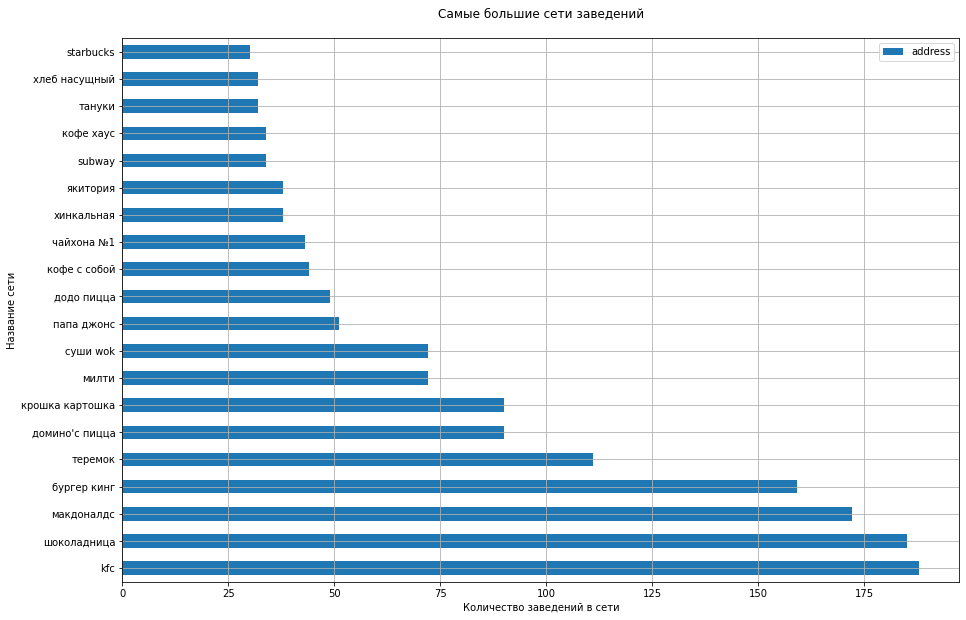

In [21]:
ax = df.plot(kind='barh', figsize=(15,10))
plt.grid()
plt.title('Самые большие сети заведений' + "\n")
plt.xlabel('Количество заведений в сети')
plt.ylabel('Название сети');

Найдем среднее количество посадочных мест в таких заведениях

In [22]:
df_1 = df_chain[df_chain['object_name'].isin(df.index)]
df_1.groupby('object_name')['number'].mean().sort_values(ascending=False)

object_name
чайхона №1         148.813953
якитория           117.157895
тануки             113.875000
макдоналдс          87.523256
шоколадница         57.648649
кофе хаус           56.617647
kfc                 55.835106
хинкальная          52.447368
бургер кинг         48.144654
starbucks           44.566667
хлеб насущный       41.937500
додо пицца          32.551020
теремок             27.144144
папа джонс          22.039216
крошка картошка     21.855556
домино'с пицца      18.344444
subway              17.352941
суши wok             6.708333
милти                1.333333
кофе с собой         0.818182
Name: number, dtype: float64

In [23]:
print('Среднее количество посадочных мест у крупных сетей: ', df_1['number'].mean())
print('Всего заведений', len(df_1['object_name']))

Среднее количество посадочных мест у крупных сетей:  48.285166240409204
Всего заведений 1564


В 20 самых крупных сетей входят 1564 заведения, среднее количество мест в них равно 48.

Выберим сети, число заведений в которых небольшое (меньше 5)

In [24]:
df_min = pd.pivot_table(df_chain, values='address', index='object_name', aggfunc='count').sort_values(by='address',ascending=False)
df_min = df_min[df_min['address'] < 5]
df_2 = df_chain[df_chain['object_name'].isin(df_min.index)]
print(f' Количество небольших сетей: {len(df_min)} \n Количество заведений в этих сетях: {len(df_2)}')

 Количество небольших сетей: 439 
 Количество заведений в этих сетях: 639


Найдем среднее количество посадочных мест

In [25]:
print('Среднее количество посадочных мест у небольших сетей: ', df_2['number'].mean())

Среднее количество посадочных мест у небольших сетей:  63.36619718309859


Получается, что у небольших сетей в среднем количество посадочных мест тоже невысокое.

Выберим только заведения с большим числом посадочных мест (больше 150)

In [26]:
print('Заведения с большим количеством посадочных мест:', len(df_2[df_2['number'] > 150]))

Заведения с большим количеством посадочных мест: 47


Исходя из полученных значений, наиболее характерно много заведений с небольшим числом посадочных мест в каждом

Определим, сколько в среднем посадочных мест предоставляет каждый вид заведения

In [27]:
pd.pivot_table(rest_data, values='number', index='object_type', aggfunc='mean').reset_index()

,object_type,number
0,бар,43.533333
1,буфет,51.509532
2,закусочная,7.825215
3,кафе,39.785703
4,кафетерий,9.184810
5,магазин (отдел кулинарии),5.589744
6,предприятие быстрого обслуживания,20.808219
7,ресторан,96.884750
8,столовая,130.337848


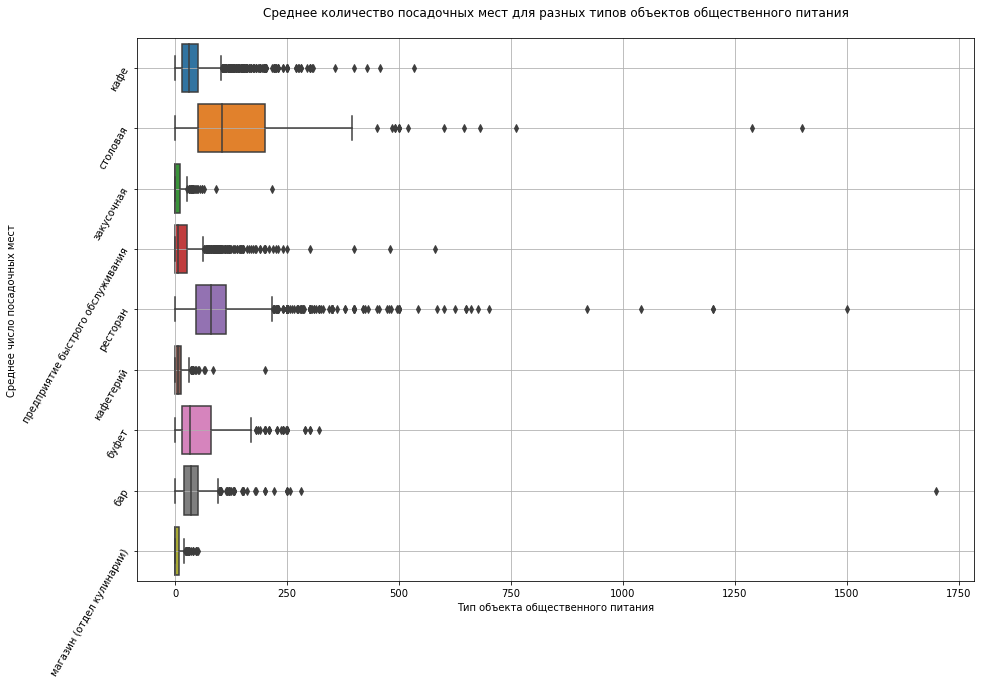

In [28]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=rest_data, x='number', y='object_type')
plt.yticks(rotation=60)
plt.grid()
plt.title('Среднее количество посадочных мест для разных типов объектов общественного питания' + "\n")
plt.xlabel('Тип объекта общественного питания')
plt.ylabel('Среднее число посадочных мест');

Из-за выбросов график не очень информативен. Уберем их, оставив при этом 99% значений

,object_type,number
0,бар,41.593677
1,буфет,50.175958
2,закусочная,7.825215
3,кафе,39.243359
4,кафетерий,9.184810
5,магазин (отдел кулинарии),5.589744
6,предприятие быстрого обслуживания,19.922914
7,ресторан,84.270871
8,столовая,119.271138


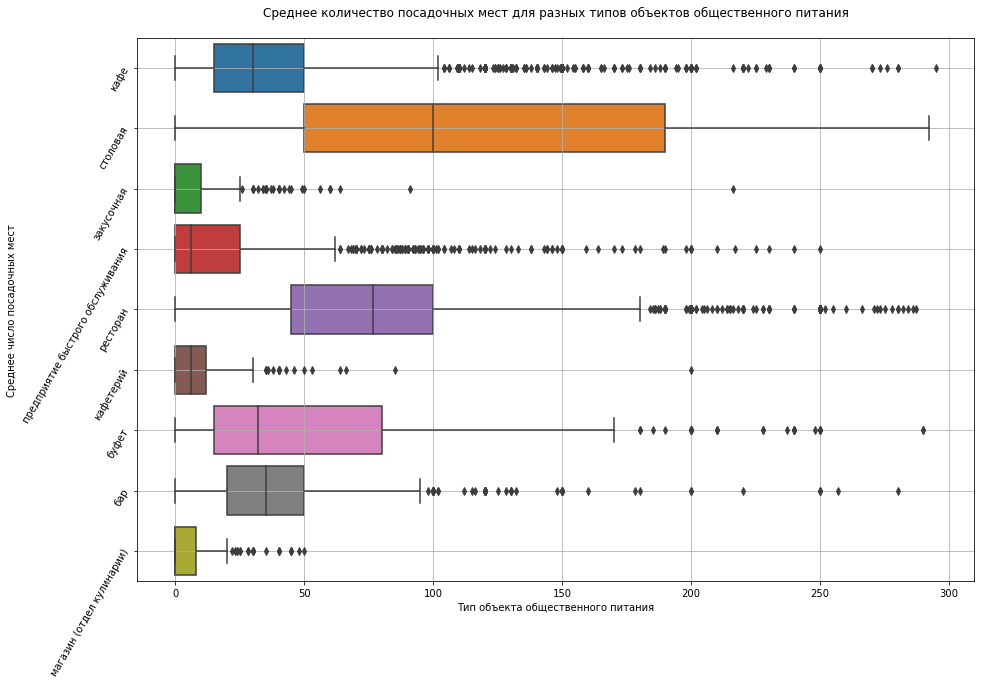

In [29]:
rest_data_99 = rest_data[rest_data['number'] < np.percentile(rest_data['number'], 99)]
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=rest_data_99, x='number', y='object_type')
plt.yticks(rotation=60)
plt.grid()
plt.title('Среднее количество посадочных мест для разных типов объектов общественного питания' + "\n")
plt.xlabel('Тип объекта общественного питания')
plt.ylabel('Среднее число посадочных мест');
pd.pivot_table(rest_data_99, values='number', index='object_type', aggfunc='mean').reset_index()

Видим, что столовые в среднем имеют 100 посадочных мест, рестораны - 80. Это логично, т.к. такие заведения предназначены для большого количества гостей. Засетим, что выбросы влияют только на эти 2 вида заведений. Меньше всего посадочных мест у магазинов (отдел кулинарии), закусочных, кафетериев. В таких заведениях люди чаще всего заказывают еду и берут с собой, а посадочные места предназначены для небольших и недолгих перекусов

### Исследование районов расположения заведений

Выделим в отдельный столбец информацию об улице из столбца `address`. Для этого создадим функцию `get_street`

In [30]:
street_def = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

def get_street(row):
    for e in row.split(','):
        for i in street_def:
            if i in e.lower():
                return e
rest_data['street'] = rest_data['address'].apply(get_street)
rest_data['street'] = rest_data['street'].str.strip()
rest_data.sample(frac=1)

,object_name,chain,object_type,address,number,street
12670,столовая,нет,столовая,"город Москва, улица Вавилова, дом 13А",85,улица Вавилова
4156,школа 1523 «кдп»,нет,столовая,"город Москва, Кленовый бульвар, дом 21",50,Кленовый бульвар
12428,бон кафе,нет,магазин (отдел кулинарии),"город Москва, улица Захарьинские Дворики, дом ...",0,улица Захарьинские Дворики
145,радэа,нет,кафе,"город Москва, Нахимовский проспект, владение 75А",7,Нахимовский проспект
3272,шато бобров,нет,ресторан,"город Москва, Бобров переулок, дом 4, строение 1",62,Бобров переулок
...,...,...,...,...,...,...
2920,столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, ст...",328,проспект Вернадского
7284,макдоналдс,да,предприятие быстрого обслуживания,"город Москва, улица Ленинская Слобода, дом 26,...",20,улица Ленинская Слобода
2155,столовая,нет,столовая,"город Москва, улица Героев Панфиловцев, дом 24",65,улица Героев Панфиловцев
13536,coffee bar,нет,кафе,"город Москва, Октябрьская улица, дом 91, корпус 1",5,Октябрьская улица


Выделим топ-10 улиц по количеству объектов общественного питания

In [31]:
rest_data_top = rest_data.groupby('street')['street'].count().sort_values(ascending=False)
rest_data_top = rest_data_top.head(10)
rest_data_top

street
проспект Мира             204
Профсоюзная улица         182
Ленинградский проспект    172
Пресненская набережная    167
Варшавское шоссе          165
Ленинский проспект        148
проспект Вернадского      128
Кутузовский проспект      114
Каширское шоссе           111
Кировоградская улица      108
Name: street, dtype: int64

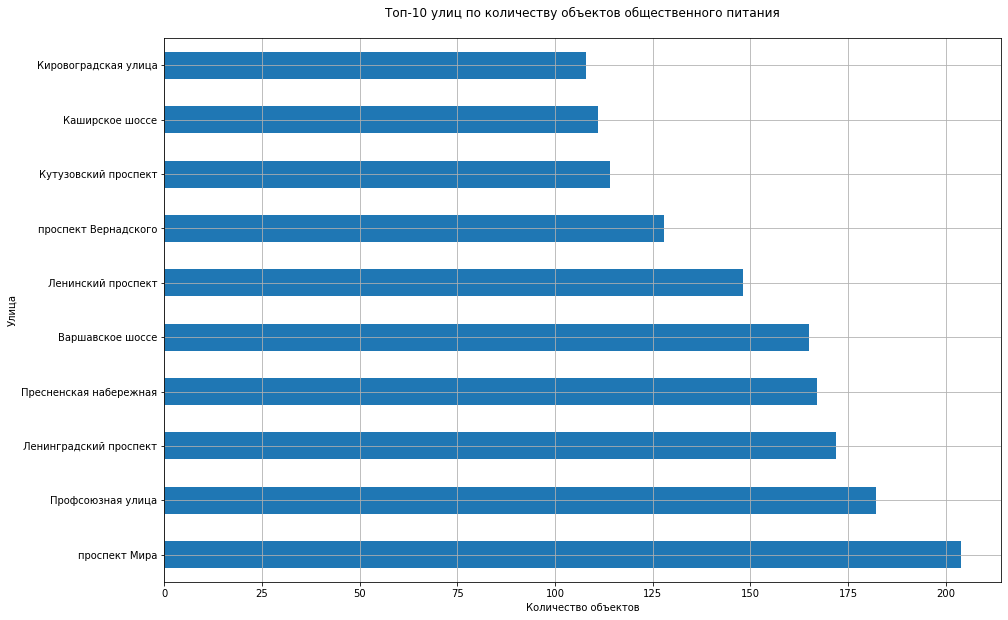

In [32]:
rest_data_top.plot(x='adress', y='street', kind='barh', title = 'Средняя цена продажи в зависомости от дня недели', figsize=(15,10)) 
plt.grid()
plt.title('Топ-10 улиц по количеству объектов общественного питания' + "\n")
plt.xlabel('Количество объектов')
plt.ylabel('Улица');

Большего всего заведений общественного питания на проспекте Мира - 204

Необходимо узнать, в каких районах Москвы находятся эти улицы?

Загрузим файл, содержащий информацию об улицах г. Москвы и районах, в которых они расположены

In [33]:
# загрузка файла из google-диска
spreadsheet_id = '1jxl5CF-KbPiS9VIBaxopGRVu2P7Qx5F6vtkYAisP1Go'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(io.BytesIO(r.content))
data

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


Если что-то не работает, то вот ссылка на csv-файл на диске: <a href ="https://drive.google.com/file/d/13P-REulP_HT0mNOvttHpaHFdGn73EPIZ/view?usp=sharing">csv</a> 

Ниже приведен код для его загрузки в проект

In [34]:
# код для альтернативной загрузки данных в проект
#filepath = "mos.csv"
#data = pd.read_csv(filepath)
#data

В таблице `data`:

* index — идентификатор строки;
* streetname - название улицы;
* areaid - идентификатор района;
* okrug - название административного округа;
* area - название района.

Выведим топ-10 улиц с указанием района и отсортируем данные по улице, а затем по району

In [35]:
rest_data_top_10 = data[data['streetname'].isin(rest_data_top.index)] # срез строк 
rest_data_top_10.sort_values(by='streetname').reset_index()

,index,streetname,areaid,okrug,area
0,3241,Варшавское шоссе,99,ЮАО,Донской район
1,4065,Варшавское шоссе,133,ЮЗАО,Район Южное Бутово
2,3125,Варшавское шоссе,110,ЮАО,Район Чертаново Южное
3,3999,Варшавское шоссе,130,ЮЗАО,Район Северное Бутово
4,3117,Варшавское шоссе,108,ЮАО,Район Чертаново Северное
5,3105,Варшавское шоссе,109,ЮАО,Район Чертаново Центральное
6,3349,Варшавское шоссе,104,ЮАО,Нагорный район
7,3305,Варшавское шоссе,102,ЮАО,Район Нагатино-Садовники
8,3308,Каширское шоссе,102,ЮАО,Район Нагатино-Садовники
9,3292,Каширское шоссе,101,ЮАО,Район Москворечье-Сабурово


In [36]:
rest_data_top_10.sort_values(by='area').reset_index()

,index,streetname,areaid,okrug,area
0,3845,Профсоюзная улица,123,ЮЗАО,Академический район
1,2293,проспект Мира,70,СВАО,Алексеевский район
2,3260,Ленинский проспект,99,ЮАО,Донской район
3,3241,Варшавское шоссе,99,ЮАО,Донской район
4,3973,Ленинский проспект,128,ЮЗАО,Ломоносовский район
5,3967,проспект Вернадского,128,ЮЗАО,Ломоносовский район
6,4334,проспект Мира,16,ЦАО,Мещанский район
7,3349,Варшавское шоссе,104,ЮАО,Нагорный район
8,3996,Профсоюзная улица,129,ЮЗАО,Обручевский район
9,3986,Ленинский проспект,129,ЮЗАО,Обручевский район


Оказалось, что одной улице могут соответствовать несколько райнов. Действительно, разные дома одной улицы могут располагаться в разных райнох Москвы. В нашем исследовании мы выбираем только улицы без учета номера дома.

Посмотрим, по каким районам проходит наибольшее число улиц из топ-10

In [37]:
print(rest_data_top_10.groupby('area')['area'].count().sort_values(ascending=False).head(20))

area
Район Чертаново Центральное    2
Донской район                  2
Ломоносовский район            2
Район Проспект Вернадского     2
Обручевский район              2
Район Теплый Стан              2
Район Нагатино-Садовники       2
Район Чертаново Южное          2
Район Тропарево-Никулино       2
Район Гагаринский              2
Район Чертаново Северное       2
Район Фили-Давыдково           1
Район Сокол                    1
Академический район            1
Район Черемушки                1
Район Свиблово                 1
Район Южное Бутово             1
Район Якиманка                 1
Район Ясенево                  1
Хорошевский район              1
Name: area, dtype: int64


Больше двух улиц нет ни в одном районе, какие конкретно, можно увидеть из таблиц выше

Найдем число улиц с одним объектом общественного питания. 

In [38]:
rest_data_low = rest_data.groupby('street')['street'].count().sort_values(ascending=False)
rest_data_low = rest_data_low[rest_data_low == 1]
len(rest_data_low)

548

Таких улиц 548

Найдем, в каких районах они расположены и отсортируем данные по улице, а затем по району

In [39]:
rest_data_low_1 = data[data['streetname'].isin(rest_data_low.index)] # срез строк 
rest_data_low_1.sort_values(by='streetname').reset_index()

,index,streetname,areaid,okrug,area
0,1834,1-й Балтийский переулок,54,САО,Район Аэропорт
1,805,1-й Басманный переулок,13,ЦАО,Басманный район
2,4213,1-й Басманный переулок,15,ЦАО,Красносельский район
3,2702,1-й Ботанический проезд,82,СВАО,Район Свиблово
4,3722,1-й Вешняковский проезд,120,ЮВАО,Рязанский район
...,...,...,...,...,...
555,2764,улица Шеногина,92,СЗАО,Район Хорошево-Мневники
556,3481,улица Шумилова,113,ЮВАО,Район Кузьминки
557,1182,улица Шумкина,26,ВАО,Район Сокольники
558,1592,улица Щорса,46,ЗАО,Район Солнцево


In [40]:
rest_data_low_1.sort_values(by='area').reset_index()

,index,streetname,areaid,okrug,area
0,2286,улица Константинова,70,СВАО,Алексеевский район
1,2289,Кулаков переулок,70,СВАО,Алексеевский район
2,2291,Кучин переулок,70,СВАО,Алексеевский район
3,2303,1-й Рижский переулок,70,СВАО,Алексеевский район
4,2304,Рижский проезд,70,СВАО,Алексеевский район
...,...,...,...,...,...
555,3421,6-я Кожуховская улица,122,ЮВАО,Южнопортовый Район
556,3426,улица Крутицкий Вал,122,ЮВАО,Южнопортовый Район
557,2397,Федоскинская улица,86,СВАО,Ярославский Район
558,2394,улица Ротерта,86,СВАО,Ярославский Район


Посмотрим, наибольшие и наименьшие значения количества улиц в одном районе

In [41]:
print(rest_data_low_1.groupby('area')['area'].count().sort_values(ascending=False).head(10))

area
Таганский район         27
Район Хамовники         26
Басманный район         25
Тверской район          20
Пресненский район       20
Район Арбат             18
Район Марьина роща      18
Мещанский район         15
Район Замоскворечье     14
Район Соколиная Гора    12
Name: area, dtype: int64


In [42]:
print(rest_data_low_1.groupby('area')['area'].count().sort_values(ascending=False).tail(20))

area
Район Северный                2
Район Северное Измайлово      2
Район Ивановское              1
Район Москворечье-Сабурово    1
Молжаниновский район          1
Район Метрогородок            1
Район Марьино                 1
Район Гагаринский             1
Район Западное Дегунино       1
Район Строгино                1
Район Филевский Парк          1
Район Марфино                 1
Район Чертаново Южное         1
Район Чертаново Северное      1
Алтуфьевский район            1
Район Лианозово               1
Район Крюково                 1
Обручевский район             1
Район Левобережный            1
Район Южное Медведково        1
Name: area, dtype: int64


Большего всего улиц проходят через Таганский район, Район Хамовники, Басманный район. Но есть районы с одной улицей, их 18.

## Выводы и рекомендации

В ходе исследования мы проанализировали особенности и характеристики заведений общественного питания в Москве. Нам необходимо оценить перспективы открытия небольшого оригинального кафе в Москве.

С точки зрения вида заведения: кафе является самым популярным, доля 39.7% от всех заведений. Среднее количество посадочных мест для кафе - 39, это значение стоит рассматривать как ориентир при выборе размеров помещения. Мы рассмотрели улицы, где расположены заведения, и районы. Можно сказать следующее: проспект Мира, Профсоюзная улица - улицы с самым большим количеством заведений. Т.е. с одной стороны такое количество обусловлено высоким спросом, что хорошо, а с другой - конкуренция очень высокая, что является негативным фактором. Также выявили улицы с 1 заведением и районы, где такие улицы расположены. Рекомендация при выборе места расположения следующая: стоит выбрать район, где есть улицы из топ-10 по количеству заведений, но при этом, чтобы также были улицы с 1 заведением в этом районе. Например, районы Чертаново Южное и Чертаново Северное подходят под это определение: там есть улицы из топ-10 с большим количеством заведений, т.е., предположительно, спрос велик, а также есть улицы с 1 заведением. Ниже выбрали такие улицы, где видно, что есть столовая и предприятие быстрого обслуживания без посадочных мест, а небольшого кафе нет, чем можно было бы воспользоваться.

Сетевых заведений от общего числа заведений в Москве - 19.4%. Из 6 071 кафе на долю сетевых приходится 23%. При этом для заведений с небольшим количеством мест, к которым можно отнести и кафе, более характерно сетевое распространение. Можно сказать, что кафе является одним из тех видов заведений, для которых открыта возможность дальнейшего развития сети.

In [43]:
rest_data_low_1[(rest_data_low_1['area'] == 'Район Чертаново Северное') | (rest_data_low_1['area'] == 'Район Чертаново Южное')]

,streetname,areaid,okrug,area
3121,Сумская улица,108,ЮАО,Район Чертаново Северное
3130,3-й Дорожный проезд,110,ЮАО,Район Чертаново Южное


In [44]:
rest_data[(rest_data['street'] == 'Сумская улица') | (rest_data['street'] == '3-й Дорожный проезд')]

,object_name,chain,object_type,address,number,street
2503,столовая школы 900,нет,столовая,"город Москва, 3-й Дорожный проезд, дом 6А",240,3-й Дорожный проезд
10435,предприятие быстрого обслуживания «шаурма»,нет,предприятие быстрого обслуживания,"город Москва, Сумская улица, дом 2/12",0,Сумская улица


## Презентация

По итогам исследования мы подготовили презентацию. Ее можно посмотреть по ссылке: <a href ="https://drive.google.com/file/d/1Og_jwXvC0NsR9JMW61_2YchZk3qarsc3/view?usp=sharing">Презентация</a>